# Modeling profitability (binary classification) using made_money

## Imports

In [1]:
pwd

'/Users/ryanrappa/Desktop/GoogleDrive/ds/kaggle_tools/notebooks'

In [2]:
cd ..

/Users/ryanrappa/Desktop/GoogleDrive/ds/kaggle_tools


In [5]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV

from src.classification import Classification, ConfusionMatrix

from xgboost import XGBClassifier
import shap

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [6]:
ls *

LICENSE.md             README.md              yellowbrick-notes.pdf

data:
bottle.csv*        clean_data_v3.csv  creditcard.csv

notebooks:
1-rlr-EDA-dev.ipynb              5-film-classn-ref.ipynb
2-rlr-regression-dev.ipynb       6-rlr-classification-dev3.ipynb
3-rlr-classification-dev1.ipynb  7-rlr-classification-dev4.ipynb
4-rlr-classification-dev2.ipynb

src:
__pycache__/       classification.py  eda.py             regression.py


In [7]:
df = pd.read_csv('data/clean_data_v3.csv')

In [8]:
df.head()

,Unnamed: 0,Unnamed: 0.1,budget,id,release_date,revenue,runtime,title,genre,profit,made_money,cast_0,cast_1,cast_2,cast_3,cast_4,director,writer,releases,cast_rev,cast_prof,cast_films,cast_prof_films,dir_rev,dir_prof,dir_films,dir_prof_films,writ_rev,writ_prof,writ_films,writ_prof_films,compet_cast_rev,compet_cast_prof,compet_cast_films,compet_cast_prof_films,compet_dir_rev,compet_dir_prof,compet_dir_films,compet_dir_prof_films,compet_writ_rev,compet_writ_prof,compet_writ_films,compet_writ_prof_films,adj_budget,cast_dir_avg_rev,month,year,decade,season,fall,spring,summer,winter,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,Thriller,War,Western,compet_budget,compet_cast_dir_avg_rev,compet_adj_budget
0,0,0,4000000.0,5,1995-12-09,4300000.0,98.0,Four Rooms,Crime,300000.0,1,Tim Roth,Antonio Banderas,Jennifer Beals,Madonna,Marisa Tomei,Allison Anders,Allison Anders,30,5.238649e+07,3.573649e+07,9.0,5.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.017498e+08,7.562609e+07,15.166667,9.333333,4.046212e+07,2.647601e+07,1.833333,1.000000,1.744469e+07,8.161356e+06,1.333333,0.500000,2.219325e+07,2.619325e+07,12,1995,1990,winter,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.500000e+07,7.110595e+07,3.610595e+07
1,1,1,11000000.0,11,1977-05-25,775398007.0,121.0,Star Wars,Adventure,764398007.0,1,Mark Hamill,Harrison Ford,Carrie Fisher,Peter Mayhew,Anthony Daniels,George Lucas,George Lucas,67,4.420000e+06,2.820000e+06,1.0,1.0,71218500.0,7.044150e+07,2.0,2.0,7.121850e+07,70441500.0,2.0,2.0,1.818402e+07,1.419652e+07,5.000000,4.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.547333e+07,-4.526667e+06,1.000000,0.000000,2.681925e+07,3.781925e+07,5,1977,1970,summer,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.300000e+06,9.092010e+06,4.792010e+06
2,2,2,94000000.0,12,2003-05-30,940335536.0,100.0,Finding Nemo,Animation,846335536.0,1,Albert Brooks,Ellen DeGeneres,Alexander Gould,Willem Dafoe,Brad Garrett,Andrew Stanton,Andrew Stanton,62,6.991528e+07,4.389605e+07,15.0,9.0,0.0,0.000000e+00,0.0,0.0,4.744807e+08,366147328.0,3.0,3.0,7.257531e+07,3.761663e+07,13.600000,9.800000,3.538779e+07,2.266113e+07,1.400000,1.200000,3.469014e+07,2.580164e+07,0.700000,0.700000,-5.904236e+07,3.495764e+07,5,2003,2000,summer,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.516619e+07,5.398155e+07,1.881536e+07
3,3,3,55000000.0,13,1994-07-06,677945399.0,142.0,Forrest Gump,Comedy,622945399.0,1,Tom Hanks,Robin Wright,Gary Sinise,Mykelti Williamson,Sally Field,Robert Zemeckis,Eric Roth,39,5.077868e+07,3.707660e+07,14.0,12.0,192273625.0,1.551070e+08,6.0,6.0,0.000000e+00,0.0,0.0,0.0,7.807074e+07,6.059212e+07,13.142857,10.857143,4.421214e+07,3.217999e+07,1.142857,1.142857,1.145317e+08,9.707339e+07,1.571429,1.571429,6.652615e+07,1.215262e+08,7,1994,1990,summer,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.071429e+07,6.114144e+07,1.042715e+07
4,4,4,15000000.0,14,1999-09-15,356296601.0,122.0,American Beauty,Drama,341296601.0,1,Kevin Spacey,Annette Bening,Thora Birch,Wes Bentley,Mena Suvari,Sam Mendes,Alan Ball,54,5.776690e+07,2.069283e+07,16.0,12.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,6.881550e+07,4.022940e+07,11.666667,8.166667,1.988473e+07,8.995846e+06,0.500000,0.333333,7.765796e+07,6.334546e+07,0.666667,0.583333,1.388345e+07,2.888345e+07,9,1999,1990,fall,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.105000e+07,4.435012e+07,1.330012e+07


#### **"Adjusted budget"** is defined as the average of the cast + director's average box office revenue to date, minus the budget of the current film they're part of. In theory this should give us some information about whether the film's budget makes sense considering the past success of the cast and director. We already have this column pertaining to films themselves, now creating it for avg competitors' adjusted budget:

## Add made_3x col

In [9]:
df['made_3x'] = df['revenue'] > 3*df['budget']
df['made_3x'] = df['made_3x'].astype('int')

In [10]:
np.mean(df['made_money'] == True)

0.7013888888888888

In [11]:
#bit of a class imbalance, but shouldn't substantially affect performance if we model on this
np.mean(df['made_3x'] == True)

0.3497222222222222

## Adding low_budget col

In [12]:
df['low_budget'] = df['budget'] <= 3000000
df['low_budget'] = df['low_budget'].astype('int')

In [13]:
df.head()

,Unnamed: 0,Unnamed: 0.1,budget,id,release_date,revenue,runtime,title,genre,profit,made_money,cast_0,cast_1,cast_2,cast_3,cast_4,director,writer,releases,cast_rev,cast_prof,cast_films,cast_prof_films,dir_rev,dir_prof,dir_films,dir_prof_films,writ_rev,writ_prof,writ_films,writ_prof_films,compet_cast_rev,compet_cast_prof,compet_cast_films,compet_cast_prof_films,compet_dir_rev,compet_dir_prof,compet_dir_films,compet_dir_prof_films,compet_writ_rev,compet_writ_prof,compet_writ_films,compet_writ_prof_films,adj_budget,cast_dir_avg_rev,month,year,decade,season,fall,spring,summer,winter,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,Thriller,War,Western,compet_budget,compet_cast_dir_avg_rev,compet_adj_budget,made_3x,low_budget
0,0,0,4000000.0,5,1995-12-09,4300000.0,98.0,Four Rooms,Crime,300000.0,1,Tim Roth,Antonio Banderas,Jennifer Beals,Madonna,Marisa Tomei,Allison Anders,Allison Anders,30,5.238649e+07,3.573649e+07,9.0,5.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.017498e+08,7.562609e+07,15.166667,9.333333,4.046212e+07,2.647601e+07,1.833333,1.000000,1.744469e+07,8.161356e+06,1.333333,0.500000,2.219325e+07,2.619325e+07,12,1995,1990,winter,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.500000e+07,7.110595e+07,3.610595e+07,0,0
1,1,1,11000000.0,11,1977-05-25,775398007.0,121.0,Star Wars,Adventure,764398007.0,1,Mark Hamill,Harrison Ford,Carrie Fisher,Peter Mayhew,Anthony Daniels,George Lucas,George Lucas,67,4.420000e+06,2.820000e+06,1.0,1.0,71218500.0,7.044150e+07,2.0,2.0,7.121850e+07,70441500.0,2.0,2.0,1.818402e+07,1.419652e+07,5.000000,4.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.547333e+07,-4.526667e+06,1.000000,0.000000,2.681925e+07,3.781925e+07,5,1977,1970,summer,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.300000e+06,9.092010e+06,4.792010e+06,1,0
2,2,2,94000000.0,12,2003-05-30,940335536.0,100.0,Finding Nemo,Animation,846335536.0,1,Albert Brooks,Ellen DeGeneres,Alexander Gould,Willem Dafoe,Brad Garrett,Andrew Stanton,Andrew Stanton,62,6.991528e+07,4.389605e+07,15.0,9.0,0.0,0.000000e+00,0.0,0.0,4.744807e+08,366147328.0,3.0,3.0,7.257531e+07,3.761663e+07,13.600000,9.800000,3.538779e+07,2.266113e+07,1.400000,1.200000,3.469014e+07,2.580164e+07,0.700000,0.700000,-5.904236e+07,3.495764e+07,5,2003,2000,summer,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.516619e+07,5.398155e+07,1.881536e+07,1,0
3,3,3,55000000.0,13,1994-07-06,677945399.0,142.0,Forrest Gump,Comedy,622945399.0,1,Tom Hanks,Robin Wright,Gary Sinise,Mykelti Williamson,Sally Field,Robert Zemeckis,Eric Roth,39,5.077868e+07,3.707660e+07,14.0,12.0,192273625.0,1.551070e+08,6.0,6.0,0.000000e+00,0.0,0.0,0.0,7.807074e+07,6.059212e+07,13.142857,10.857143,4.421214e+07,3.217999e+07,1.142857,1.142857,1.145317e+08,9.707339e+07,1.571429,1.571429,6.652615e+07,1.215262e+08,7,1994,1990,summer,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.071429e+07,6.114144e+07,1.042715e+07,1,0
4,4,4,15000000.0,14,1999-09-15,356296601.0,122.0,American Beauty,Drama,341296601.0,1,Kevin Spacey,Annette Bening,Thora Birch,Wes Bentley,Mena Suvari,Sam Mendes,Alan Ball,54,5.776690e+07,2.069283e+07,16.0,12.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,6.881550e+07,4.022940e+07,11.666667,8.166667,1.988473e+07,8.995846e+06,0.500000,0.333333,7.765796e+07,6.334546e+07,0.666667,0.583333,1.388345e+07,2.888345e+07,9,1999,1990,fall,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.105000e+07,4.435012e+07,1.330012e+07,1,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 76 columns):
Unnamed: 0                 3600 non-null int64
Unnamed: 0.1               3600 non-null int64
budget                     3600 non-null float64
id                         3600 non-null int64
release_date               3600 non-null object
revenue                    3600 non-null float64
runtime                    3600 non-null float64
title                      3600 non-null object
genre                      3600 non-null object
profit                     3600 non-null float64
made_money                 3600 non-null int64
cast_0                     3600 non-null object
cast_1                     3600 non-null object
cast_2                     3600 non-null object
cast_3                     3600 non-null object
cast_4                     3600 non-null object
director                   3600 non-null object
writer                     3600 non-null object
releases                   36

In [15]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'budget', 'id', 'release_date', 'revenue', 'runtime', 'title',
       'genre', 'profit', 'made_money', 'cast_0', 'cast_1', 'cast_2', 'cast_3', 'cast_4',
       'director', 'writer', 'releases', 'cast_rev', 'cast_prof', 'cast_films', 'cast_prof_films',
       'dir_rev', 'dir_prof', 'dir_films', 'dir_prof_films', 'writ_rev', 'writ_prof', 'writ_films',
       'writ_prof_films', 'compet_cast_rev', 'compet_cast_prof', 'compet_cast_films',
       'compet_cast_prof_films', 'compet_dir_rev', 'compet_dir_prof', 'compet_dir_films',
       'compet_dir_prof_films', 'compet_writ_rev', 'compet_writ_prof', 'compet_writ_films',
       'compet_writ_prof_films', 'adj_budget', 'cast_dir_avg_rev', 'month', 'year', 'decade',
       'season', 'fall', 'spring', 'summer', 'winter', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'None', 'Romance', 'Science Fiction', 'Thriller', 'War

## Sort data by date

In [20]:
df = df.sort_values('release_date')

In [23]:
df.tail()

,Unnamed: 0,Unnamed: 0.1,budget,id,release_date,revenue,runtime,title,genre,profit,made_money,cast_0,cast_1,cast_2,cast_3,cast_4,director,writer,releases,cast_rev,cast_prof,cast_films,cast_prof_films,dir_rev,dir_prof,dir_films,dir_prof_films,writ_rev,writ_prof,writ_films,writ_prof_films,compet_cast_rev,compet_cast_prof,compet_cast_films,compet_cast_prof_films,compet_dir_rev,compet_dir_prof,compet_dir_films,compet_dir_prof_films,compet_writ_rev,compet_writ_prof,compet_writ_films,compet_writ_prof_films,adj_budget,cast_dir_avg_rev,month,year,decade,season,fall,spring,summer,winter,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,None,Romance,Science Fiction,Thriller,War,Western,compet_budget,compet_cast_dir_avg_rev,compet_adj_budget,made_3x,low_budget
3517,3517,3517,42000000.0,426563,2018-12-25,40462793.0,90.0,Holmes & Watson,Mystery,-1537207.0,0,Will Ferrell,John C. Reilly,Rebecca Hall,Ralph Fiennes,Hugh Laurie,Etan Cohen,Etan Cohen,17,2.257616e+08,1.515874e+08,67.0,53.0,1.118115e+08,7.181145e+07,1.0,1.0,613963565.0,426463565.0,2.0,2.0,1.265104e+08,8.130527e+07,44.0,34.0,2.643849e+08,1.586974e+08,4.0,3.5,344610398.0,268860398.0,2.0,2.0,1.267865e+08,1.687865e+08,12,2018,2010,winter,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,95000000.0,1.954476e+08,1.004476e+08,0,0
3539,3539,3539,37500000.0,440472,2019-01-10,111353135.0,123.0,The Upside,Comedy,73853135.0,1,Kevin Hart,Bryan Cranston,Nicole Kidman,Julianna Margulies,Aja Naomi King,Neil Burger,Jon Hartmere,13,1.000618e+08,6.608987e+07,55.0,43.0,1.618495e+08,1.348495e+08,1.0,1.0,0.0,0.0,0.0,0.0,1.288633e+08,8.680120e+07,81.0,60.0,2.339860e+08,1.602717e+08,7.0,6.0,242254630.5,161129630.5,8.0,7.0,9.345563e+07,1.309556e+08,1,2019,2010,spring,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20000000.0,1.814246e+08,1.614246e+08,0,0
3556,3556,3556,20000000.0,450465,2019-01-16,243765250.0,129.0,Glass,Thriller,223765250.0,1,James McAvoy,Bruce Willis,Samuel L. Jackson,Anya Taylor-Joy,Sarah Paulson,M. Night Shyamalan,M. Night Shyamalan,29,1.288633e+08,8.680120e+07,81.0,60.0,2.339860e+08,1.602717e+08,7.0,6.0,242254630.5,161129630.5,8.0,7.0,1.000618e+08,6.608987e+07,55.0,43.0,1.618495e+08,1.348495e+08,1.0,1.0,0.0,0.0,0.0,0.0,1.614246e+08,1.814246e+08,1,2019,2010,spring,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,37500000.0,1.309556e+08,9.345563e+07,1,0
3195,3195,3195,152000000.0,299537,2019-03-06,910298835.0,124.0,Captain Marvel,Action,758298835.0,1,Brie Larson,Samuel L. Jackson,Jude Law,Ben Mendelsohn,Annette Bening,Ryan Fleck,Geneva Robertson-Dworet,31,1.811165e+08,1.186573e+08,72.0,52.0,0.000000e+00,0.000000e+00,0.0,0.0,274650803.0,180650803.0,1.0,1.0,2.586218e+08,2.146552e+08,4.0,2.0,2.550173e+08,2.505173e+08,1.0,1.0,255017329.0,250517329.0,1.0,1.0,-6.144174e+07,9.055826e+07,3,2019,2010,spring,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20000000.0,2.568196e+08,2.368196e+08,1,0
3568,3568,3568,20000000.0,458723,2019-03-14,107058805.0,116.0,Us,Thriller,87058805.0,1,Lupita Nyong'o,Winston Duke,Elisabeth Moss,Tim Heidecker,Shahadi Wright Joseph,Jordan Peele,Jordan Peele,36,2.586218e+08,2.146552e+08,4.0,2.0,2.550173e+08,2.505173e+08,1.0,1.0,255017329.0,250517329.0,1.0,1.0,1.811165e+08,1.186573e+08,72.0,52.0,0.000000e+00,0.000000e+00,0.0,0.0,274650803.0,180650803.0,1.0,1.0,2.368196e+08,2.568196e+08,3,2019,2010,spring,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,152000000.0,9.055826e+07,-6.144174e+07,1,0


## Drop non-numerical, unnecessary, and unreasonable assumption cols

In [24]:
X_cols = ['budget',
          'runtime', 
          'releases', 
          'cast_rev', 
          'cast_prof', 
          'cast_films', 
          'cast_prof_films', 
          'dir_rev',
          'dir_prof', 
          'dir_films', 
          'dir_prof_films', 
          'writ_rev', 
          'writ_prof', 
          'writ_films', 
          'writ_prof_films', 
          'adj_budget',
          'cast_dir_avg_rev',
          'fall', 'spring', 'summer', 'winter',
          'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'None', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western',
          'low_budget']


# y_col = 'made_3x'
y_col = 'made_money'

X = df.loc[:, X_cols].values
y = df.loc[:, y_col].values.ravel()
#need to use ravel for y array to be correct shape for analysis, 
#otherwise np.mean(y_pred == y_test) does not work properly later

print(X.shape)
print(y.shape)

print(np.mean(y == 1))

(3600, 40)
(3600,)
0.7013888888888888


## Trying SGDClassifier (had issues with plain elastic net)

In [19]:
clf = Classification(df, X_cols, y_col)

In [20]:
%%time
alphas = np.logspace(-3, 1, 25)
l1_ratios = [0, .5, 1]
folds = 5
model, preds = clf.elastic_net_sgd(alphas, l1_ratios, folds)

-------- BEST MODEL --------
SGDClassifier(alpha=0.0031622776601683794, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
-------- ---------- --------
CPU times: user 1.07 s, sys: 69.3 ms, total: 1.13 s
Wall time: 7.64 s


releases            1.110691
cast_prof_films     0.525127
cast_prof           0.444502
dir_prof_films      0.324547
dir_prof            0.234756
low_budget          0.208099
writ_prof_films     0.184198
summer              0.180927
Comedy              0.150486
dir_rev             0.132054
Horror              0.118568
runtime             0.098538
Family              0.088001
Animation           0.078786
History             0.063762
Music               0.058706
Western             0.052282
winter              0.049582
Science Fiction     0.017639
writ_rev            0.015487
writ_prof           0.015465
Crime               0.000944
spring             -0.013359
budget             -0.027850
Thriller           -0.030079
Romance            -0.038548
Mystery            -0.039858
None               -0.043386
Fantasy            -0.045560
Adventure          -0.049929
Action             -0.093857
War                -0.095731
Drama              -0.107969
cast_dir_avg_rev   -0.132403
adj_budget    

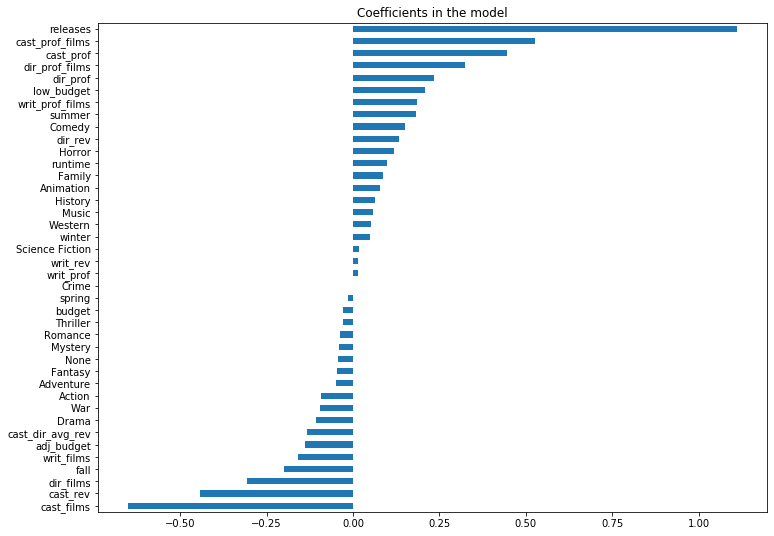

In [21]:
%%time
clf.coefficient_plot(model)

### Evaluation metrics

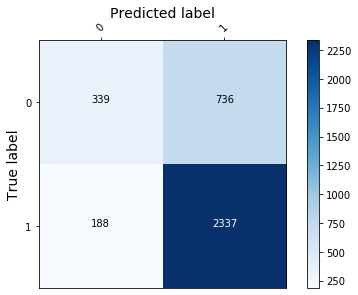

Accuracy =      0.743
Precision =     0.760
Recall (TPR) =  0.926
Fallout (FPR) = 0.685

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.64      0.32      0.42      1075
           1       0.76      0.93      0.83      2525

    accuracy                           0.74      3600
   macro avg       0.70      0.62      0.63      3600
weighted avg       0.73      0.74      0.71      3600



In [22]:
cm = ConfusionMatrix(y, preds, model)
cm.plot_matrix()

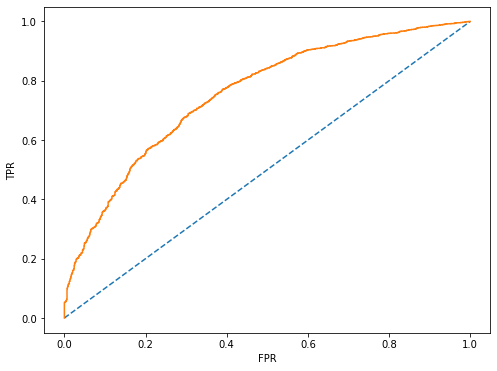

Best ratio w/ TPR > .5: 3.1172186184135655
    Decision threshold: 0.7632363677781884
                   TPR: 0.5045544554455446
                   FPR: 0.16186046511627908
CPU times: user 275 ms, sys: 6.36 ms, total: 281 ms
Wall time: 196 ms


/Users/ryanrappa/Desktop/GoogleDrive/ds/kaggle_tools/src/classification.py:229: RuntimeWarning: invalid value encountered in double_scalars
  if tp/fp > best_ratio and tp > 0.5:
/Users/ryanrappa/Desktop/GoogleDrive/ds/kaggle_tools/src/classification.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  if tp/fp > best_ratio and tp > 0.5:


In [24]:
%%time
clf.roc_curve(model)

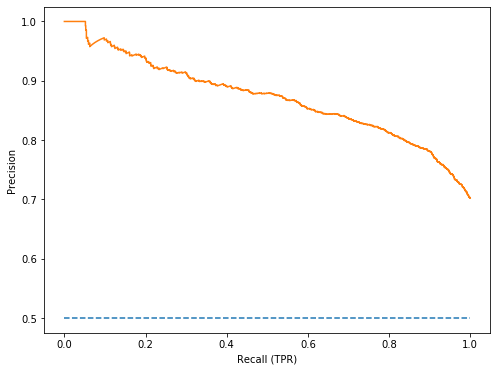

P/R ratio closest to 1: 0.9996041171813143
    Decision threshold: 0.6069515177952478
             Precision: 0.8091844813935075
                Recall: 0.8095049504950496
CPU times: user 289 ms, sys: 6.13 ms, total: 295 ms
Wall time: 175 ms


In [25]:
%%time
clf.pr_curve(model)

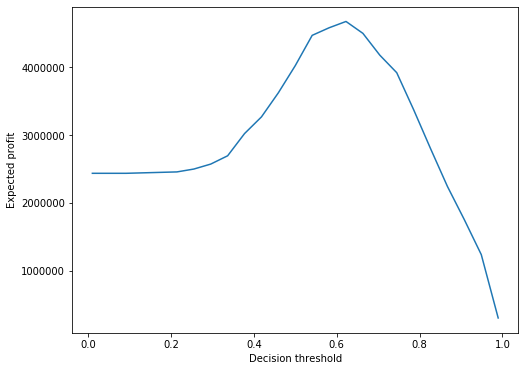

Estimated max avg profit: 4675224.72
      Decision threshold: 0.6225


In [26]:
#assign costs / benefits
cost_bene = {
'tp': 13945744,     #median profit of profitable movies / 3 (divided by 3 to be more conservative)
'fp': -24599094,    #median loss of unprofitable movies x 3 (multip. by 3 to be more conservative)
'tn': 0,            #not making an unprofitable movie costs us nothing (could also consider opp. cost)
'fn': 0 }           #not making a profitable movie costs us nothing (could also consider opp. cost)

thresholds = np.linspace(.01, .99, 25)

clf.profit_curve(thresholds, model, cost_bene)

## Robust feature importances

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


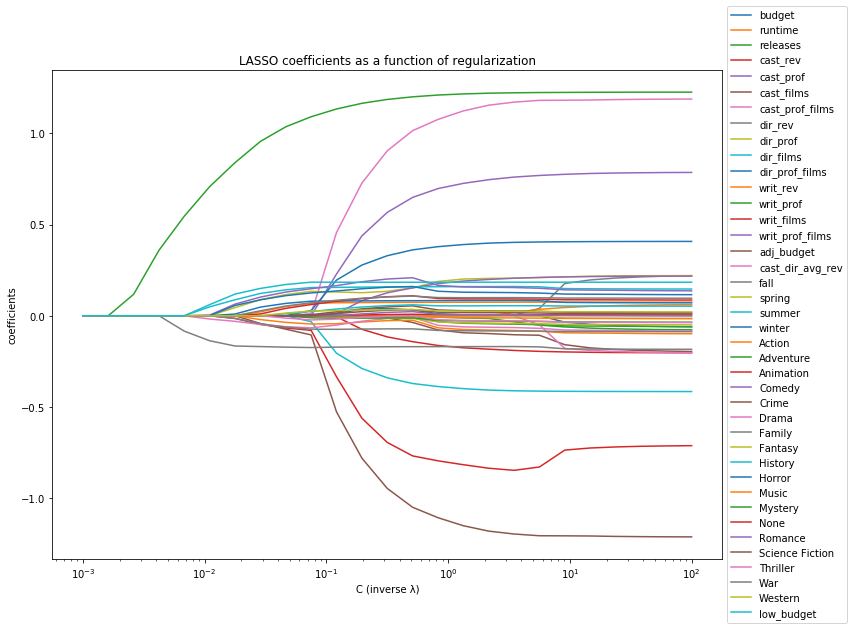

CPU times: user 14.3 s, sys: 127 ms, total: 14.4 s
Wall time: 14.7 s


In [23]:
%%time
clf.lasso_plot(np.logspace(2, -3, 25))

## So SGD Logistic Reg. isn't great, let's try Gradient boosting

In [28]:
params = {
        'eta': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], #equiv. to learning rate/shrinkage
        'n_estimators': [100, 200, 300, 400, 500, 1000]
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
        }

In [25]:
def xgboost(parameters, folds, X, y, n_iter=32, **kwargs): 
    #modify and add this + time series version to classification class
    '''
    Runs parallelized BayesSearchCV for optimal gradient
    boosted (xgboost) model over the specified parameters.

    Notes:
        ~in progress~

    Args:
        parameters
        folds (int): Number of folds to use in cross validation.
        X
        y
        n_iter
        all kwargs: 

    Returns:
        model (obj): BayesSearchCV optimized gradient boost model.
        preds (np array): Predicted values of target.

    Raises:
        ~in progress~

    Example:
        parameters = ###
        folds = 5
        model, preds = clf.xgboost(parameters, folds)

    '''
    xgb = XGBClassifier(nthread=1) #default scoring is logistic loss
    model = RandomizedSearchCV(xgb, parameters, cv=folds, n_jobs=-1, n_iter=n_iter, **kwargs) 
    model.fit(X, y)
    preds = model.predict(X)
    print("-------- BEST MODEL --------")
    print(model.best_estimator_)
    print("-------- ---------- --------")
    return model, preds

In [31]:
%%time
model, preds = xgboost(params, 5)

-------- BEST MODEL --------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
-------- ---------- --------
CPU times: user 1.45 s, sys: 64 ms, total: 1.51 s
Wall time: 3min 47s


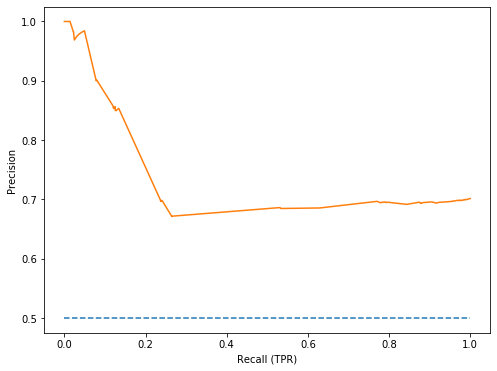

P/R ratio closest to 1: 0.9043696275071632
    Decision threshold: 0.7656716
             Precision: 0.6966332378223495
                Recall: 0.7702970297029703


In [33]:
clf.pr_curve(model)

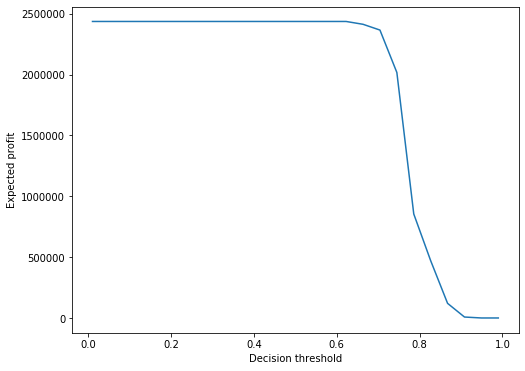

Estimated max avg profit: 2435827.097222222
      Decision threshold: 0.01


In [34]:
clf.profit_curve(thresholds, model, cost_bene)

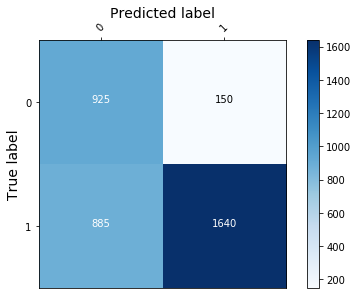

Accuracy =      0.713
Precision =     0.916
Recall (TPR) =  0.650
Fallout (FPR) = 0.140

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.51      0.86      0.64      1075
           1       0.92      0.65      0.76      2525

    accuracy                           0.71      3600
   macro avg       0.71      0.75      0.70      3600
weighted avg       0.80      0.71      0.72      3600



In [36]:
preds_75 = (model.predict_proba(X)[:,1] >= 0.75).astype(bool)

cm = ConfusionMatrix(y, preds_75, model)
cm.plot_matrix()

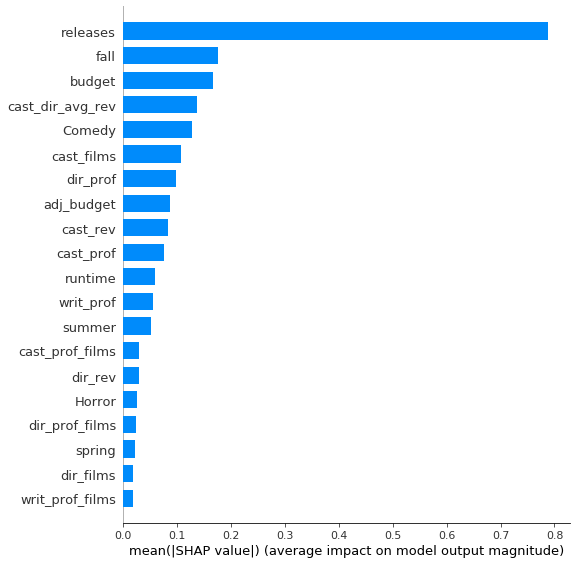

In [37]:
explainer = shap.TreeExplainer(model.best_estimator_)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=X_cols)

### XGBoost - training and checking performance with held out test set

In [39]:
#train-test split with scaled data - avoiding data leakage by scaling train and test sets separately
scaler = StandardScaler()
skf = StratifiedKFold(n_splits = 5, shuffle = True)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = scaler.fit(X[train_index]).transform(X[train_index]), y[train_index]
    X_test, y_test = scaler.fit(X[test_index]).transform(X[test_index]), y[test_index]
    break

In [40]:
%%time
model, preds = xgboost(params, 5, X_train, y_train)

-------- BEST MODEL --------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
-------- ---------- --------
CPU times: user 1.4 s, sys: 140 ms, total: 1.54 s
Wall time: 3min 10s


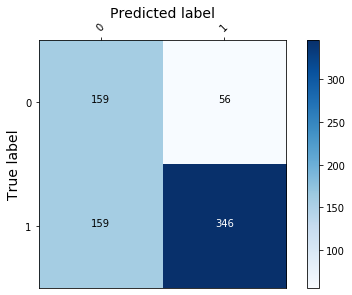

Accuracy =      0.701
Precision =     0.861
Recall (TPR) =  0.685
Fallout (FPR) = 0.260

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.50      0.74      0.60       215
           1       0.86      0.69      0.76       505

    accuracy                           0.70       720
   macro avg       0.68      0.71      0.68       720
weighted avg       0.75      0.70      0.71       720



In [180]:
test_preds = model.predict(X_test)
test_preds_75 = (model.predict_proba(X_test)[:,1] >= 0.74).astype(bool)

cm = ConfusionMatrix(y_test, test_preds_75, model)
cm.plot_matrix()

In [115]:
np.mean(preds == 1)

0.809375

In [229]:
def profit_estimator(df, model, X_cols, sample_size=5, num_samples=5000):
    '''
    '''
    profits = []
    for s in range(num_samples):
        profit = 0
        sample_idxs = df[X_cols].sample(n=sample_size).index.tolist()
        X = df[X_cols].loc[sample_idxs, :].values
        X_scaled = scaler.fit(X).transform(X)
        preds = model.predict(X)
        pred_df = df.loc[sample_idxs, :]
        pred_df['pred_profit'] = preds
        for idx in sample_idxs:
            if pred_df.loc[idx, 'pred_profit'] == 0:
                continue
            else:
                profit += pred_df.loc[idx, 'profit']
        profits.append(profit)
        
    print("mean:", np.mean(profits), " median:", np.median(profits), " min:", min(profits), " max:", max(profits), " st dev:", np.std(profits))
    
    #add historgram for simulated returns
    
    return np.mean(profits), np.median(profits), min(profits), max(profits), np.std(profits), profits

In [230]:
mean, med, min_, max_, std, arr = profit_estimator(df, model, X_cols, sample_size=5)

mean: 349911188.0012  median: 249624704.5  min: -112041877.0  max: 3763979894.0  st dev: 350008338.55516


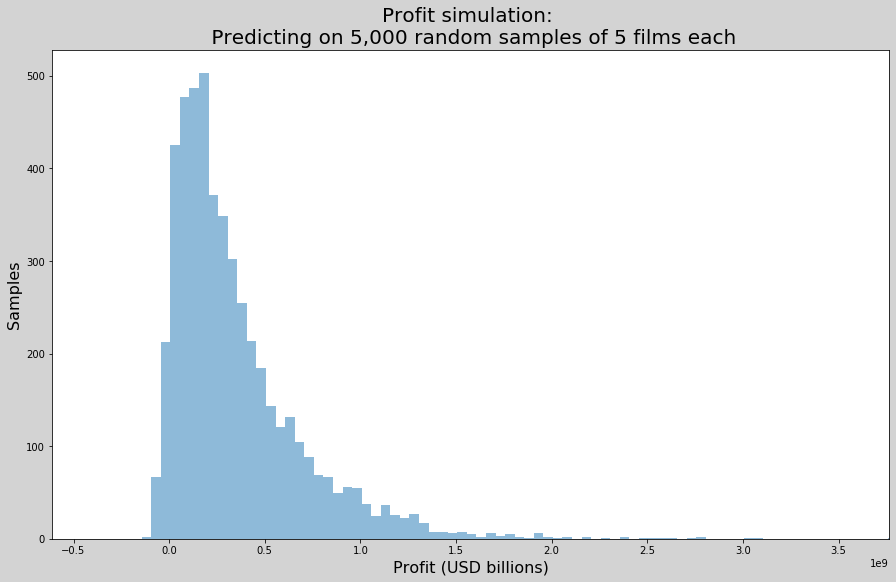

Percent of samples with positive profit: 0.9546
Median (USD millions): +249.6


In [234]:
bins = np.arange(-193560818.0, 3967539093.0, 50000000) # fixed bin size

plt.figure(figsize=(15,9), facecolor='#D3D3D3')
plt.xlim([min(arr)-500000000, max(arr)+50000])
plt.hist(arr, bins=bins, alpha=0.5)
plt.title('Profit simulation: \n Predicting on 5,000 random samples of 5 films each', 
         fontdict={'fontsize': 20})
plt.xlabel('Profit (USD billions)', fontdict={'fontsize': 16})
plt.ylabel('Samples', fontdict={'fontsize': 16})

plt.show()

print("Percent of samples with positive profit:", np.mean([num > 0 for num in arr]))
print("Median (USD millions):", '+' + str(round(med/1000000, 1)))

### Breaking out simulation by low budget and high

In [185]:
def profit_estimator_lb(df, model, X_cols, sample_size=5, num_samples=5000):
    '''
    '''
    profits = []
    for s in range(num_samples):
        profit = 0
        sample_idxs = df[X_cols][df['low_budget'] == 1].sample(n=sample_size).index.tolist()
        X = df[X_cols].loc[sample_idxs, :].values
        X_scaled = scaler.fit(X).transform(X)
        preds = model.predict(X)
        pred_df = df.loc[sample_idxs, :]
        pred_df['pred_profit'] = preds
        for idx in sample_idxs:
            if pred_df.loc[idx, 'pred_profit'] == 0:
                continue
            else:
                profit += pred_df.loc[idx, 'profit']
        profits.append(profit)
        
    print("mean:", np.mean(profits), " median:", np.median(profits), " min:", min(profits), " max:", max(profits), " st dev:", np.std(profits))
    
    #add historgram for simulated returns
    
    return np.mean(profits), np.median(profits), min(profits), max(profits), np.std(profits), profits

def profit_estimator_hb(df, model, X_cols, sample_size=5, num_samples=5000):
    '''
    '''
    profits = []
    for s in range(num_samples):
        profit = 0
        sample_idxs = df[X_cols][df['low_budget'] == 0].sample(n=sample_size).index.tolist()
        X = df[X_cols].loc[sample_idxs, :].values
        X_scaled = scaler.fit(X).transform(X)
        preds = model.predict(X)
        pred_df = df.loc[sample_idxs, :]
        pred_df['pred_profit'] = preds
        for idx in sample_idxs:
            if pred_df.loc[idx, 'pred_profit'] == 0:
                continue
            else:
                profit += pred_df.loc[idx, 'profit']
        profits.append(profit)
        
    print("mean:", np.mean(profits), " median:", np.median(profits), " min:", min(profits), " max:", max(profits), " st dev:", np.std(profits))
    
    #add historgram for simulated returns
    
    return np.mean(profits), np.median(profits), min(profits), max(profits), np.std(profits), profits

In [235]:
#functions in hidden cell above
mean, med, min_, max_, std, arr = profit_estimator_lb(df, model, X_cols, sample_size=5)

mean: 55437298.3968  median: 36054387.5  min: -7616491.0  max: 458570545.0  st dev: 59135110.71639348


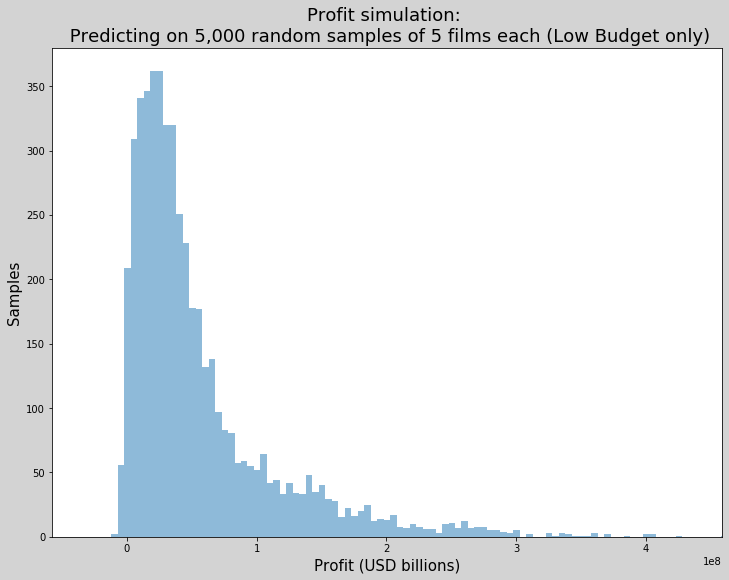

Percent of samples with positive profit: 0.9744
Median (USD millions): +36.1


In [239]:
bins = np.arange(-17065995.0, 596882893, 5000000) # fixed bin size

plt.figure(figsize=(12,9), facecolor='#D3D3D3')
plt.xlim([min(arr)-50000000, max(arr)+50000])
plt.hist(arr, bins=bins, alpha=0.5)
plt.title('Profit simulation: \n Predicting on 5,000 random samples of 5 films each (Low Budget only)', 
         fontdict={'fontsize': 18})
plt.xlabel('Profit (USD billions)', fontdict={'fontsize': 15})
plt.ylabel('Samples', fontdict={'fontsize': 15})

plt.show()

print("Percent of samples with positive profit:", np.mean([num > 0 for num in arr]))
print("Median (USD millions):", '+' + str(round(med/1000000, 1)))

In [240]:
mean, med, min_, max_, std, arr = profit_estimator_hb(df, model, X_cols, sample_size=5)

mean: 396502357.1132  median: 290754582.5  min: -156609320.0  max: 3121658676.0  st dev: 374842770.3596796


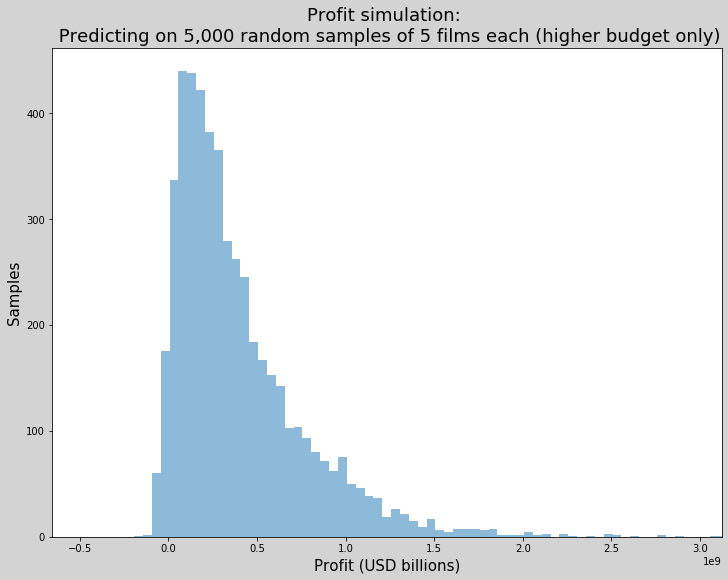

Percent of samples with positive profit: 0.958
Median (USD millions): +290.8


In [242]:
bins = np.arange(-193560818.0, 3967539093.0, 50000000) # fixed bin size


plt.figure(figsize=(12,9), facecolor='#D3D3D3')
plt.xlim([min(arr)-500000000, max(arr)+50000])
plt.hist(arr, bins=bins, alpha=0.5)
plt.title('Profit simulation: \n Predicting on 5,000 random samples of 5 films each (higher budget only)', 
         fontdict={'fontsize': 18})
plt.xlabel('Profit (USD billions)', fontdict={'fontsize': 15})
plt.ylabel('Samples', fontdict={'fontsize': 15})

plt.show()

print("Percent of samples with positive profit:", np.mean([num > 0 for num in arr]))
print("Median (USD millions):", '+' + str(round(med/1000000, 1)))

## More thorough RandomizedSearch (params as lists)

In [19]:
np.linspace(.1, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [20]:
params = {
        'eta': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], #equiv. to shrinkage (aka learning rate)
        'n_estimators': [100, 200, 300, 400, 500, 1000], #number of trees
        'min_child_weight': [1, 5, 10], #analogous to min num of observations per leaf, in this case
        'gamma': [0, 0.5, 1, 1.5, 2, 5], #Minimum loss reduction required to make a further split on a leaf node.
        'subsample': [0.6, 0.8, 1.0], #fraction of observations (rows) to randomly sample for each tree
        'colsample_bytree': [0.6, 0.8, 1.0], #fraction of features (cols) to randomly sample for each tree
        'max_depth': [3, 6, 9, 12] #max number of splits/interaction depth per tree
        }

In [21]:
params

{'eta': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
 'n_estimators': [100, 200, 300, 400, 500, 1000],
 'min_child_weight': [1, 5, 10],
 'gamma': [0, 0.5, 1, 1.5, 2, 5],
 'subsample': [0.6, 0.8, 1.0],
 'colsample_bytree': [0.6, 0.8, 1.0],
 'max_depth': [3, 6, 9, 12]}

In [22]:
#train-test split with scaled data - avoiding data leakage by scaling train and test sets separately
scaler = StandardScaler()
skf = StratifiedKFold(n_splits = 5, shuffle = True)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = scaler.fit(X[train_index]).transform(X[train_index]), y[train_index]
    X_test, y_test = scaler.fit(X[test_index]).transform(X[test_index]), y[test_index]
    break

In [26]:
%%time
model, preds = xgboost(params, 5, X_train, y_train, n_iter=64)

-------- BEST MODEL --------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.01, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
-------- ---------- --------
CPU times: user 1.92 s, sys: 183 ms, total: 2.1 s
Wall time: 7min 38s


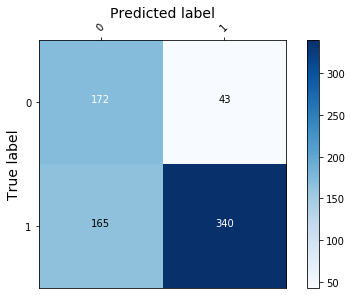

Accuracy =      0.711
Precision =     0.888
Recall (TPR) =  0.673
Fallout (FPR) = 0.200

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.51      0.80      0.62       215
           1       0.89      0.67      0.77       505

    accuracy                           0.71       720
   macro avg       0.70      0.74      0.69       720
weighted avg       0.78      0.71      0.72       720



In [27]:
test_preds = model.predict(X_test)
test_preds_75 = (model.predict_proba(X_test)[:,1] >= 0.74).astype(bool)

cm = ConfusionMatrix(y_test, test_preds_75, model)
cm.plot_matrix()

In [28]:
np.mean(preds == 1)
#went from 80 previously to 78.75 now

0.7875

### Trying same but with n_iter=128 (didn't perform better)

In [29]:
%%time
model, preds = xgboost(params, 5, X_train, y_train, n_iter=128)

-------- BEST MODEL --------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.001, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)
-------- ---------- --------
CPU times: user 2.89 s, sys: 275 ms, total: 3.17 s
Wall time: 16min 49s


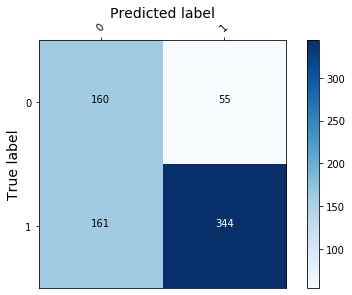

Accuracy =      0.700
Precision =     0.862
Recall (TPR) =  0.681
Fallout (FPR) = 0.256

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.50      0.74      0.60       215
           1       0.86      0.68      0.76       505

    accuracy                           0.70       720
   macro avg       0.68      0.71      0.68       720
weighted avg       0.75      0.70      0.71       720



In [32]:
test_preds = model.predict(X_test)
test_preds_75 = (model.predict_proba(X_test)[:,1] >= 0.74).astype(bool)

cm = ConfusionMatrix(y_test, test_preds_75, model)
cm.plot_matrix()

## More thorough RandomizedSearch 2 (params as distributions)

In [71]:
from scipy.stats import uniform, randint, expon

In [77]:
params = {
        'eta': uniform(loc=0.0001, scale=0.3), #[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], #Equiv. to shrinkage (aka learning rate)
        'n_estimators': randint(100, 1000), #[100, 200, 300, 400, 500, 1000], #Num of trees
        'min_child_weight': randint(1, 10), #[1, 5, 10], #Analogous to min num of observations per leaf, in this case
        'gamma': expon(), #[0, 0.5, 1, 1.5, 2, 5], #Min loss reduction required to make a further split on a leaf node.
        'subsample': uniform(loc=.6, scale=.4), #[0.6, 0.8, 1.0], #Pct of observations (rows) to randomly sample for each tree
        'colsample_bytree': uniform(loc=.6, scale=.4), #[0.6, 0.8, 1.0], #Pct of features (cols) to randomly sample for each tree
        'max_depth': randint(3, 12), #[3, 6, 9, 12] #Max number of splits/interaction depth per tree
        }

In [78]:
params

{'eta': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1f601240>,
 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1f6011d0>,
 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1f601128>,
 'gamma': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1fb31518>,
 'subsample': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1fb0a5c0>,
 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1fb0acc0>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x1c1fb0ad30>}

In [79]:
#train-test split with scaled data - avoiding data leakage by scaling train and test sets separately
scaler = StandardScaler()
skf = StratifiedKFold(n_splits = 5, shuffle = True)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = scaler.fit(X[train_index]).transform(X[train_index]), y[train_index]
    X_test, y_test = scaler.fit(X[test_index]).transform(X[test_index]), y[test_index]
    break

In [80]:
%%time
iterations = 64 #number of models, trades off runtime for model performance
model, preds = xgboost(params, 5, X_train, y_train, n_iter=iterations)

-------- BEST MODEL --------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8063884532607343,
              eta=0.1055908692377631, gamma=0.294735933590237,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=135, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7108054821707062, verbosity=1)
-------- ---------- --------
CPU times: user 2.11 s, sys: 180 ms, total: 2.29 s
Wall time: 10min 20s


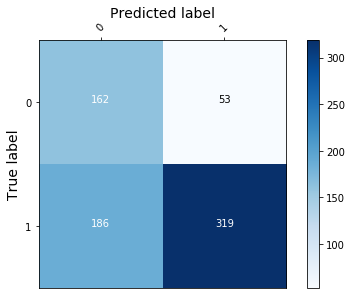

Accuracy =      0.668
Precision =     0.858
Recall (TPR) =  0.632
Fallout (FPR) = 0.247

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.47      0.75      0.58       215
           1       0.86      0.63      0.73       505

    accuracy                           0.67       720
   macro avg       0.66      0.69      0.65       720
weighted avg       0.74      0.67      0.68       720



In [83]:
test_preds = model.predict(X_test)
test_preds_75 = (model.predict_proba(X_test)[:,1] >= 0.74).astype(bool)

cm = ConfusionMatrix(y_test, test_preds_75, model)
cm.plot_matrix()